In [ ]:
%pip install gensim Cython pyLDAvis[gpu]

In [14]:
import os
os.getcwd()

'd:\\Documents\\Personal\\projects\\sandoz\\sandoz_data_task\\notebooks\\lda_exploration'

In [ ]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt




from gensim.models import CoherenceModel
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


import gensim.corpora as corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import nltk
import string
import warnings
from tqdm import tqdm

In [17]:

def boa_to_df(boa):

    if len(boa['opponents_reps']) == 0:
        opponents = pd.DataFrame()
    else:
        opponents = pd.concat([
        pd.DataFrame({f"Opponent {i+1}":[v[0]], f"Representative {i+1}":[v[1]]}) for i,v in enumerate(boa['opponents_reps'])
        ], axis=1)
    
    return pd.concat([
    pd.DataFrame.from_dict({
        "Decision date" : [boa['date']],
        "Case number" : [boa['case_number']],
        "Application number" : [boa['application_number']],
        "Publication number" : [boa['publication_number']],
        "IPC pharma" : [boa['IPC pharma']],
        "IPC biosimilar" : [boa['IPC biosimilar']],
        "IPCs" : [", ".join(boa['IPC'])],
        "Language" : [boa['lang']],
        "Title of Invention" : [boa['title_of_invention']],
        "Patent Proprietor" : [boa['patent_proprietor']],
        "Headword" : [boa['headword']],
        "Provisions" : [", ".join(boa['provisions'])],
        "Keywords" : [', '.join(boa['keywords'])],
        "Decisions cited" : [', '.join(boa['decisions_cited'])],
        "Summary" : ['\n\n'.join(boa['summary'])],
        "Decision reasons" : ['\n\n'.join(boa['decision_reasons'])],
        "Order" : [', '.join(boa['order'])],
        "Order status" : [boa['Order_status']],
        "Order status web" : [boa['Order_status_web']],
        "Order status manual" : [boa['Order_status_manual']],
        "Opponents" : [', '.join(boa['opponents'])]  
    }),
    opponents
    ], axis=1)

def drop_duplicate_languages(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function returns unique cases without duplication across languages. Keeps only English if English + other lang is avbl, then keeps only german, and takes french for the rest.
    """
    en_cases = df[df['Language']=='EN']

    #Find the case numbers in df that are not in en_cases
    case_numbers = [x for x in df['Case number'].unique() if x not in en_cases['Case number'].unique()]

    # For the rest of the cases, keep the german versions only (in case they exist in both DE and FR)
    rest_de_df = df[(df['Case number'].isin(case_numbers)) & (df['Language'] == 'DE')]
    
    all_cases = pd.concat([en_cases, rest_de_df])

    # If there are any cases in french only, add them last.
    rest_fr_df = df[(~df['Case number'].isin(all_cases['Case number'])) & (df['Language'] == 'FR')]

    all_cases = pd.concat([all_cases, rest_fr_df])

    return all_cases

def load_data():
    with open('../../data/raw/BOA_database_for_exercise_from_2020.json', 'r') as f:
        boa_pharma = json.load(f)
   
    boa_table = pd.concat([ boa_to_df(boa) for boa in boa_pharma], axis = 0)
    cases_df_dedup = drop_duplicate_languages(boa_table)

    return cases_df_dedup.reset_index(drop=True)

def preprocess_text(text_series):
    
    stop_words = set(stopwords.words('english'))
    stop_words.update('request')
    stop_words.update('claim')
    stop_words.update('composition')
    lemmatizer = WordNetLemmatizer()

    def clean(doc):
        tokens = word_tokenize(doc.lower())
        tokens = [t for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if t not in stop_words]
        tokens = [lemmatizer.lemmatize(t, pos='n') for t in tokens]
        tokens = [lemmatizer.lemmatize(t, pos='v') for t in tokens]
        tokens = [lemmatizer.lemmatize(t, pos='a') for t in tokens]
        tokens = [lemmatizer.lemmatize(t, pos='r') for t in tokens]
        tokens = [lemmatizer.lemmatize(t, pos='s') for t in tokens]
        return tokens

    return text_series.dropna().apply(clean)


def topic_modeling(series, num_topics=4, passes=10):
    
    texts = preprocess_text(series)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=passes,
        per_word_topics=True
    )

    topics = lda_model.print_topics()
    for idx, topic in topics:
        print(f"Topic #{idx}: {topic}\n")

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
    print(f"Coherence Score: {coherence:.4f}")

    return lda_model, coherence


def plot_coherence_range(text_series, topic_range=range(2, 11), passes=10):
    texts = preprocess_text(text_series)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    coherence_values = []
    models = []

    for num_topics in tqdm(topic_range):
        model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=passes,
            per_word_topics=True
        )
        models.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append(coherence)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(list(topic_range), coherence_values, marker='o')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.title("Coherence Score vs. Number of Topics")
    plt.grid(True)
    plt.show()

    return list(zip(topic_range, coherence_values)), models


def dump_ldavis_html(lda_model, corpus, dictionary, filename='ldavis.html'):
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.save_html(vis, filename)
    print(f"LDA Visualization saved to {filename}")

In [18]:
raw_data = load_data()
raw_data = raw_data[raw_data['Language'] == 'EN']

# How many topics in title?

100%|██████████| 13/13 [00:55<00:00,  4.24s/it]


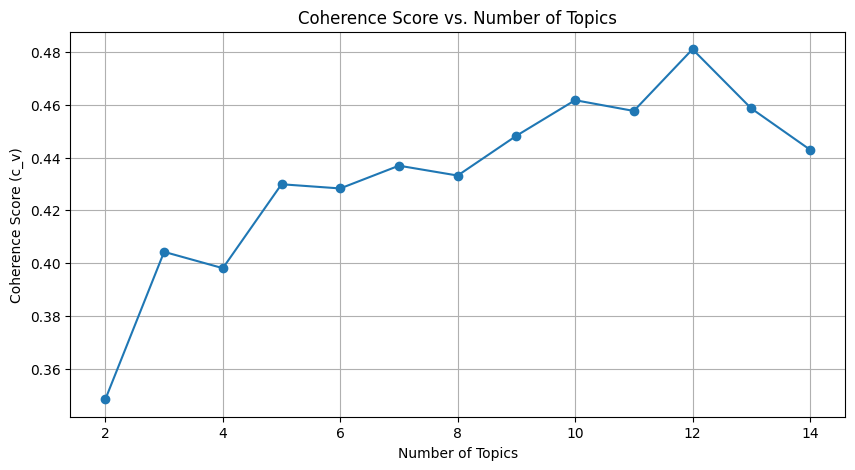

In [ ]:
topics_title, lda_models_title = plot_coherence_range(raw_data['Title of Invention'], topic_range=range(2, 15), passes=10)

### No clear trend in coherece, nTopics not separating well.

In [ ]:
vis_html = gensimvis.prepare(title12, title12_corpus, title12_dict)
pyLDAvis.save_html(vis_html, 'title11.html')


# How many topics in summmary

100%|██████████| 13/13 [04:58<00:00, 22.92s/it]


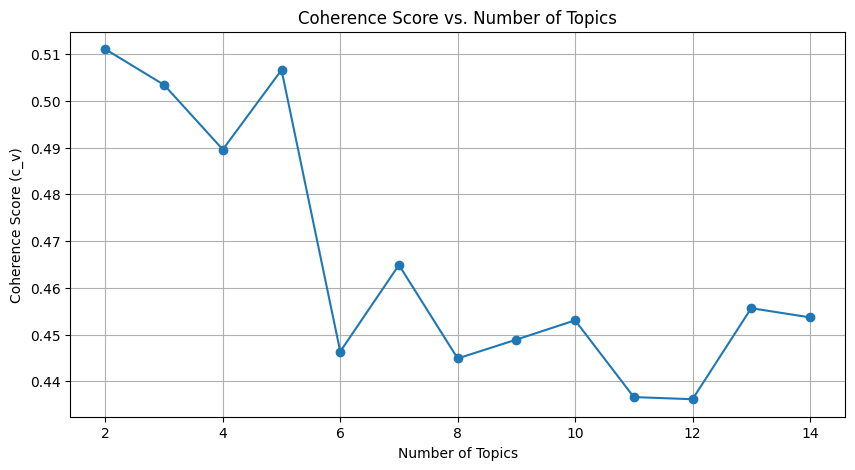

In [9]:
topcs_summary, lda_models_summary = plot_coherence_range(raw_data['Summary'], topic_range=range(2, 15), passes=10)

### No clear number of topics

# How many topics in Order?

100%|██████████| 13/13 [01:08<00:00,  5.26s/it]


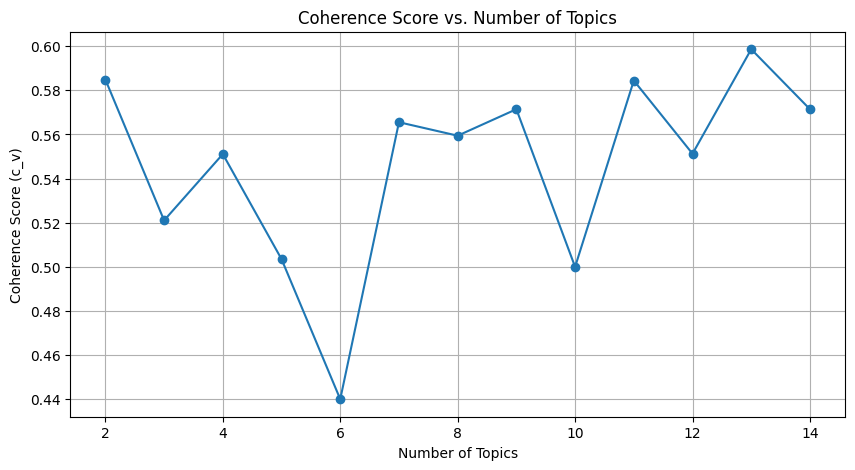

In [10]:
topics_order, lda_models_order = plot_coherence_range(raw_data['Order'], topic_range=range(2, 15), passes=10)

### No clear number of topics

# How many topics in headword

100%|██████████| 13/13 [00:46<00:00,  3.59s/it]


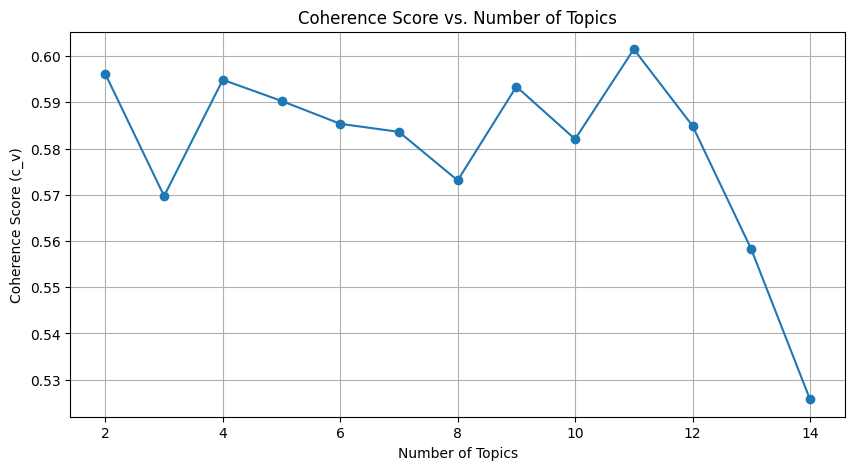

In [11]:
topics_headword, lda_models_headword = plot_coherence_range(raw_data['Headword'], topic_range=range(2, 15), passes=10)

C (Chemistry, Metallurgy): 419 (74.29%)
A (Human Necessities): 50 (8.87%)
H (Electricity): 20 (3.55%)
B (Performing Operations, Transporting): 68 (12.06%)
G (Physics): 6 (1.06%)
F (Mechanical Engineering, Lighting, Heating, Weapons): 1 (0.18%)


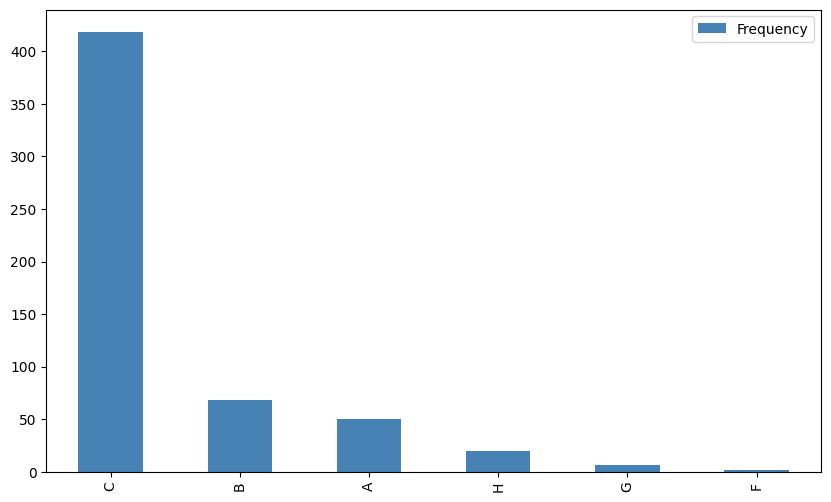

In [ ]:
def get_IPC_classification(x):
    """
    This function returns the IPC classification of a case.
    """
    IPC_CLASSIFICATIONS = {'A': 'Human Necessities',
    'B': 'Performing Operations, Transporting',
    'C': 'Chemistry, Metallurgy',
    'D': 'Textiles, Paper',
    'E': 'Fixed Constructions',
    'F': 'Mechanical Engineering, Lighting, Heating, Weapons',
    'G': 'Physics',
    'H': 'Electricity'}

    return IPC_CLASSIFICATIONS[x]


# Learning: we have some non-pharma but they're not biosimilars.
from collections import Counter
my_counter = Counter()
raw_data[raw_data['IPC pharma'] == 0]['IPCs'].apply(lambda x: x.replace(' ','').split(',')).apply(lambda y: [x[0] for x in y]).apply(lambda x: my_counter.update(x));


# When we have non-pharma IPCs, the most common categories are 
for k in my_counter.keys():
    print(f"{k} ({get_IPC_classification(k)}): {my_counter[k]} ({100*my_counter[k]/np.sum([x for x in my_counter.values()]):.2f}%)")

# Learning: Chemistry is the most common category, and operations comes up much more commonly than for pharma (>12x)
pd.DataFrame(my_counter, index=['Frequency']).T.sort_values('Frequency', ascending=False).head(20).plot(kind='bar', figsize=(10, 6), color='steelblue');

### No clear separation of topics